In [1]:
import os
import copy
import numpy as np
import scipy
import pandas
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Introduction to Linear Discriminant Analysis (LDA)

Dataset: breast cancer

## Load data

In [2]:
df = pl.read_csv("breast_cancer.csv")
df

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
842302,"""M""",17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
842517,"""M""",20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
84300903,"""M""",19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
84348301,"""M""",11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
84358402,"""M""",20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
926424,"""M""",21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623,1.176,1.256,7.673,158.7,0.0103,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115
926682,"""M""",20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.0395,0.01678,0.01898,0.002498,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
926954,"""M""",16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.0473,0.01557,0.01318,0.003892,18.98,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782


In [3]:
columns = df.columns
print("Columns:", columns)

target = "diagnosis"
classes = list(df[target].unique())
dct_classes = {k: v for v, k in enumerate(classes)}
print("Classes:", classes)

# Irrelevant column for classification: "id"
df = df.drop("id")

Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Classes: ['M', 'B']


## Plot data

In [4]:
# select two features
features = ["radius_mean", "texture_mean"]

df_mini = df.select(features + [target])
df_mini

radius_mean,texture_mean,diagnosis
f64,f64,str
17.99,10.38,"""M"""
20.57,17.77,"""M"""
19.69,21.25,"""M"""
11.42,20.38,"""M"""
20.29,14.34,"""M"""
…,…,…
21.56,22.39,"""M"""
20.13,28.25,"""M"""
16.6,28.08,"""M"""


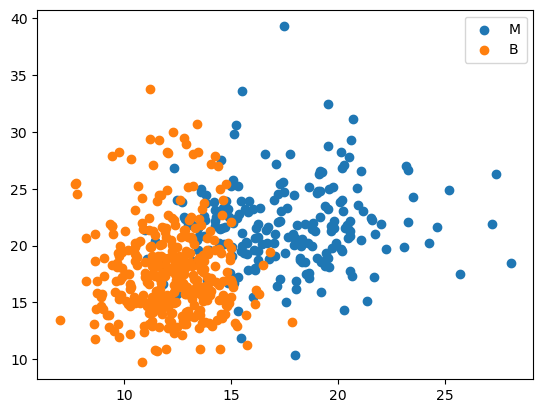

In [5]:
for cl in classes:
    data = df_mini.filter(pl.col(target) == cl).select(features)
    data = data.to_numpy()
    plt.scatter(data[:,0], data[:,1], label = cl)
    
plt.legend()

## By-hand: LDA and QDA

### Two features (mini)

Select the features and make the train/test split.

In [6]:
K = len(classes)

df_train, df_test = train_test_split(df, test_size = .2)

Xm = df[features].to_numpy()
y = df[target].to_numpy()
Xm_train = df_train[features].to_numpy()
y_train = df_train[target].to_numpy()
Xm_test = df_test[features].to_numpy()
y_test = df_test[target].to_numpy()

**Quesion 1**

We will perform a LDA. Compute the parameters of the model.

Contour plots of the Gaussians of the model.

In [7]:
from scipy.stats import multivariate_normal

xmin, xmax = Xm[:,0].min(), Xm[:,0].max()
ymin, ymax = Xm[:,1].min(), Xm[:,1].max()

x_, y_ = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
for mean, cl in zip(lst_X_means, classes):
    rv = multivariate_normal(mean, X_cov)
    data = np.dstack((x_, y_))
    z = rv.pdf(data)
    plt.contour(x_, y_, z, colors = "black")
    
    data = df_train.filter(pl.col(target) == cl).select(features)
    data = data.to_numpy()
    plt.scatter(data[:,0], data[:,1], label = cl)
plt.show()

NameError: name 'lst_X_means' is not defined

**Question 2**

Write a function `compute_log_posterior`, computing the log posterior of a data point, given the model.

Plot of the decision boundary.

In [ ]:
lst_prior = [k / n for k in lst_n]

x_, y_ = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
data = np.dstack((x_, y_))
z = np.zeros([data.shape[0], data.shape[1]])
for i, zdata in enumerate(data):
    for j, dpoint in enumerate(zdata):
        z[i, j] = np.argmax(compute_log_posterior(dpoint, lst_X_means, [X_cov] * K, lst_prior))
plt.contourf(x_, y_, z)

for cl in classes:
    data = df_train.filter(pl.col(target) == cl).select(features)
    data = data.to_numpy()
    plt.scatter(data[:,0], data[:,1], label = cl)

plt.show()

**Question 3**

Write a function computing the accuracy (or score) of a dataset, given the parameters of the LDA.

Computation of the train/test scores.

In [ ]:
classif_score_train = compute_score(Xm_train, y_train, lst_X_means, [X_cov] * K, lst_prior)
print(f"Train score: {classif_score_train:.2f}")

classif_score_test = compute_score(Xm_test, y_test, lst_X_means, [X_cov] * K, lst_prior)
print(f"Test score: {classif_score_test:.2f}")

### Many features (large)

Select all the features.

In [ ]:
Xl = df.drop(target)
Xl_train = df_train.drop(target).to_numpy()
Xl_test = df_test.drop(target).to_numpy()

features = Xl.columns
Xl = Xl.to_numpy()

**Question 4**

Compute the parameters of the LDA model and compute the train/test scores.

### Quadratic Discriminant Analysis (QDA)

**Quesion 5**

Compute the parameters of the QDA and compute the train/test scores.

## With sklearn: LDA and QDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

**Question 6**

Perform LDA and QDA using sklearn. Compute the cross-validation scores. Compare with knns.